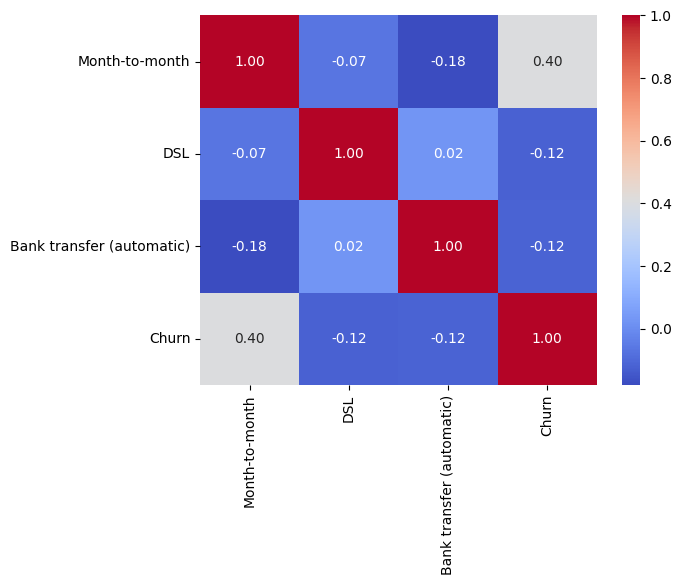

Churn
0.0    5163
1.0    1869
Name: count, dtype: int64
Churn
0.0    4130
1.0    4130
Name: count, dtype: int64
Churn
0.0    5163
1.0    1869
Name: count, dtype: int64
Index(['Partner', 'Dependents', 'PaperlessBilling', 'OnlineSecurity',
       'TechSupport', 'Churn', 'DSL', 'Fiber optic', 'No_internet',
       'Month-to-month', 'One year', 'Two year', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'tenure',
       'MonthlyCharges', 'TotalCharges', 'SeniorCitizen'],
      dtype='object')


,Partner,Dependents,PaperlessBilling,OnlineSecurity,TechSupport,Churn,DSL,Fiber optic,No_internet,Month-to-month,One year,Two year,Bank transfer (automatic),Credit card (automatic),Electronic check,tenure,MonthlyCharges,TotalCharges,SeniorCitizen
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.280248,-1.161694,-0.994194,0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.064303,-0.260878,-0.173740,0
2,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.239504,-0.363923,-0.959649,0
3,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.512486,-0.747850,-0.195248,0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.239504,0.196178,-0.940457,0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

import warnings 
warnings.filterwarnings('ignore')


df=pd.read_csv("C:\ML\dataset_task1.csv")

# we dont need customerid
df=df.drop(columns=['customerID'])

#assigning proper datatype
df['TotalCharges']=df['TotalCharges'].replace(' ',np.nan)
df=df.dropna(subset=['TotalCharges'],axis=0)
df['TotalCharges']=df['TotalCharges'].astype(float)


#'no internet service' is getting repeated in many columns which can perform data leakage
#to handle that 
No_internet_containing_columns=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for c in No_internet_containing_columns:
    df[c]=df[c].replace('No internet service','No')
#similarly to handle 'no phone service' getting repeated
df['MultipleLines']=df['MultipleLines'].replace('No phone service','No')



#encoding
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
ohe=OneHotEncoder(sparse_output=False)


scalar=StandardScaler()
yes_no_cols = ['Partner', 'Dependents', 'PhoneService','MultipleLines', 'PaperlessBilling','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Churn']
multi_cat_cols = ['InternetService', 'Contract', 'PaymentMethod']
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
ode=OrdinalEncoder(categories=[['No','Yes']] * len(yes_no_cols))
ode2=OrdinalEncoder(categories=[['Female','Male']])
#drop=first is used to prevent multicollinarity
ct=make_column_transformer(
    (ode,yes_no_cols),
    (ode2,['gender']),
    (ohe,multi_cat_cols),
    (scalar,numerical_cols),
    remainder='passthrough'
)
ct.set_output(transform='pandas')
transformed_df=ct.fit_transform(df)


#handling column names
strings_to_remove=['ordinalencoder-1__','ordinalencoder-2__','onehotencoder__InternetService_','onehotencoder__Contract_','onehotencoder__PaymentMethod_','standardscaler__','remainder__']
pattern='|'.join(strings_to_remove)
transformed_df.columns = transformed_df.columns.str.replace(pattern, '', regex=True)
transformed_df.columns = transformed_df.columns.str.replace('No','No_internet')

#checking correlation
sample_df=transformed_df.loc[:,['Month-to-month','DSL','Bank transfer (automatic)','Churn']]
corr_checking_df=sample_df.corr()
sns.heatmap(corr_checking_df,annot=True,cmap='coolwarm',fmt='.2f',xticklabels=corr_checking_df.columns,yticklabels=corr_checking_df.columns)
plt.show()

#tenure has a correlation of 0.35
#month to month=0.41
#deviceprotection and onlinebackup have a correlation of 0.07 and 0.08 
#streamingtv and streamingmovies have a correlation of 0.06
#fibre optic has a correlation of 0.31
#twoyear and no have a correlation of 0.23 and 0.3 
#electronic check =0.3
#mailed check=0.09
#multipleLines=0.04
#gender and phoneservice has a correlation of 0.01
#removing cols with correation less than 0.1
transformed_df=transformed_df.drop(columns=['gender','PhoneService','MultipleLines','Mailed check','DeviceProtection','OnlineBackup','StreamingTV', 'StreamingMovies'])


#sampling the dataset
from sklearn.model_selection import StratifiedShuffleSplit
X=transformed_df.drop(columns=['Churn'])
y=transformed_df.Churn
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_idx,test_idx in split.split(X,y):
    X_train,X_test=X.iloc[train_idx],X.iloc[test_idx]
    y_train,y_test=y.iloc[train_idx],y.iloc[test_idx]
print(transformed_df.Churn.value_counts())


#smote-oversampling
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42)
X_resampled,y_resampled=smote.fit_resample(X_train,y_train)
class_count=y_resampled.value_counts()
print(class_count)





print(transformed_df.Churn.value_counts())

print(transformed_df.columns)
transformed_df.head()



In [2]:
#using LogisticRegression
from sklearn.linear_model import LogisticRegression
classifier=LogisticRegression()


#hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
parameter={'penalty':['l1','l2','elasticnet'],'C':[1,5,10,15,20,50,75,100] ,'max_iter':[100,200,500]}
classifier_regressor=GridSearchCV(classifier,param_grid=parameter,scoring='accuracy',cv=5)
classifier_regressor.fit(X_resampled,y_resampled)
print(classifier_regressor.best_params_)
print('best_score:',classifier_regressor.best_score_)
y_preds=classifier_regressor.predict(X_test)


# #checking performance
from sklearn.metrics import accuracy_score,classification_report
print('score:',accuracy_score(y_preds,y_test))
print('classification_report:',classification_report(y_preds,y_test))

{'C': 5, 'max_iter': 100, 'penalty': 'l2'}
best_score: 0.7595641646489104
score: 0.7711442786069652
classification_report:               precision    recall  f1-score   support

         0.0       0.75      0.93      0.83       835
         1.0       0.83      0.55      0.66       572

    accuracy                           0.77      1407
   macro avg       0.79      0.74      0.74      1407
weighted avg       0.78      0.77      0.76      1407



In [3]:
#using RandomForestRegressor -- Bagging
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(random_state=42)
parameters_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None,'balanced']
}
rf_grid = RandomizedSearchCV(
    estimator=rf,
    param_distributions=parameters_grid,
    n_iter=30,        # only test 30 random combos instead of all 960
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42
)
rf_grid.fit(X_resampled, y_resampled)
y_preds_rf=rf_grid.predict(X_test)

print("Best parameters:", rf_grid.best_params_)
print("Best score:", rf_grid.best_score_)
print('score:',accuracy_score(y_preds_rf,y_test))
print('classification_report:',classification_report(y_preds_rf,y_test))

Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'class_weight': 'balanced'}
Best score: 0.8407484071260042
score: 0.7839374555792467
classification_report:               precision    recall  f1-score   support

         0.0       0.84      0.86      0.85      1007
         1.0       0.63      0.59      0.61       400

    accuracy                           0.78      1407
   macro avg       0.73      0.72      0.73      1407
weighted avg       0.78      0.78      0.78      1407



In [4]:
#XGBoost--boosting
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',   
    use_label_encoder=False,
    random_state=42
)


params_xgb = {
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
}


xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params_xgb,
    n_iter=30,        
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42
)


xgb_random.fit(X_resampled, y_resampled)

print("Best parameters:", xgb_random.best_params_)
print("Best score:", xgb_random.best_score_)


y_pred = xgb_random.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.8}
Best score: 0.8296342259997542
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85      1033
         1.0       0.57      0.63      0.60       374

    accuracy                           0.78      1407
   macro avg       0.72      0.73      0.72      1407
weighted avg       0.79      0.78      0.78      1407



In [5]:
#lda as a model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda=LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)
y_preds_lda=lda.predict(X_test)
print(classification_report(y_test, y_preds_lda))
#f1_score:0.72

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1033
         1.0       0.65      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407

